<b>

<p>
<center>
<font size="5">

</font>
</center>
</p>

<p>
<center>
<font size="5">
COVID-19 Open Research Dataset Challenge (CORD-19)
</font>
</center>
</p>

<p>
<center>
<font size="4">
Authors: Chao Zhou, Ruijin Jia, Matteo Bucalossi
</font>
</center>
</p>

<p>
<center>
<font size="3">
Machine Learning I (DATS 6202), Spring 2020
</font>
</center>
</p>

<p>
<center>
<font size="2">
[GitHub Repository](https://github.com/matteobucalossi50/CORD-19-Challenge)
</font>
</center>
</p>

</b>

### Introduction

Last month, in response to the global COVID-19 pandemic, the White House and other leading research institutions, including the Allen Institute for AI, have prepared the COVID-19 Open Research Dataset (CORD-19): this dataset includes over 57,000 scholarly articles, most of them with full text, about COVID-19, SARS-CoV-2, and related coronaviruses. As literature published keeps increasing in scale, the medical community would need AI tools to quickly gain insights and directions to fight this disease in a timely manner.  
Kaggle has issued a [competition](https://www.kaggle.com/allen-institute-for-ai/CORD-19-research-challenge) to develop such tools to help the medical community for this high priority scientific challenge. The public dataset represents a highly readable and clean collection of materials, and it is beeing updated constantly as more publications are released and added to the corpus.  

Thanks to the minimal work on pre-processing required by this dataset, we decided to apply a Transformer model to extract sentence embeddings for machine learning task-specific "heads". Given that the pre-trained transformer by the UKPLab uses BERT, we decided to train and fine-tune the same transformer on SciBERT by Allen AI to obtain more relevant embeddings for a scientific and medical corpus.  
We then used said embeddings to train different clustering algorithms for unsupervised learning: we used UAMP for dimensionality reduction, and HDBSCAN for density-based clustering while LDA for probability-based clustering. Also, we integrated a semantic search algorithm based on cosine similarity that can take user questions (we recommend to take ideas from [Tasks](https://www.kaggle.com/allen-institute-for-ai/CORD-19-research-challenge/tasks)) and provides the top 5 relevant articles from the corpus.

# Data Preprocessing

Luckily the dataset had already been cleaned for the most part, and we only had to create an hashable corpus of text from json files. Once we had the body text and the abstact for each article, and its relevant metadata, in a dataframe, we cleaned the text columns of odd characters using regex.  Here we call the [preprocessing](https://github.com/matteobucalossi50/CORD-19-Challenge/blob/master/scripts/preprocessing.py) script to obtain a clean dataframe to use for our machine learning tasks.

In [1]:
### load preprocessing.py
### print dataframe.head or something
import numpy as np
import pandas as pd
import os
import glob
import json
# import scispacy
import spacy
import tqdm
import matplotlib.pyplot as plt

from scripts import preprocessing 

In [2]:
######################################testing###################################
# directories and paths
root_path = os.getcwd()
metadata_path = f'{root_path}/data/all_sources_metadata_2020-03-13.csv'
metadata = pd.read_csv(metadata_path)
metadata.head()
metadata.info()
# read all paths of json file(paper)
all_json = glob.glob(f'{root_path}/data/**/*.json', recursive=True) 
print(len(all_json))
######################################testing###################################

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29500 entries, 0 to 29499
Data columns (total 14 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   sha                          17420 non-null  object 
 1   source_x                     29500 non-null  object 
 2   title                        29130 non-null  object 
 3   doi                          26357 non-null  object 
 4   pmcid                        27337 non-null  object 
 5   pubmed_id                    16730 non-null  float64
 6   license                      17692 non-null  object 
 7   abstract                     26553 non-null  object 
 8   publish_time                 18248 non-null  object 
 9   authors                      28554 non-null  object 
 10  journal                      17791 non-null  object 
 11  Microsoft Academic Paper ID  1134 non-null   float64
 12  WHO #Covidence               1236 non-null   object 
 13  has_full_text   

In [3]:
def nan_checker(df):
    
    # Get the variables with NaN, their proportion of NaN and dtype
    df_nan = pd.DataFrame([[var, df[var].isna().sum() / df.shape[0], df[var].dtype]
                           for var in df.columns if df[var].isna().sum() > 0],
                          columns=['var', 'proportion', 'dtype'])
    
    # Sort df_nan in accending order of the proportion of NaN
    df_nan = df_nan.sort_values(by='proportion', ascending=False).reset_index(drop=True)
    
    return df_nan
nan_checker(metadata)

,var,proportion,dtype
0,Microsoft Academic Paper ID,0.961559,float64
1,WHO #Covidence,0.958102,object
2,pubmed_id,0.432881,float64
3,sha,0.409492,object
4,has_full_text,0.409492,object
5,license,0.400271,object
6,journal,0.396915,object
7,publish_time,0.381424,object
8,doi,0.106542,object
9,abstract,0.099898,object


In [4]:
# drop the rows where abstract is missing
metadata.dropna(subset = ['abstract'],axis = 0, inplace = True)
#check dimension of new dataset
print(metadata.shape)
metadata.head()

(26553, 14)


,sha,source_x,title,doi,pmcid,pubmed_id,license,abstract,publish_time,authors,journal,Microsoft Academic Paper ID,WHO #Covidence,has_full_text
2,210a892deb1c61577f6fba58505fd65356ce6636,CZI,Incubation Period and Other Epidemiological Ch...,10.3390/jcm9020538,NaN,NaN,cc-by,The geographic spread of 2019 novel coronaviru...,2020,"Linton, M. Natalie; Kobayashi, Tetsuro; Yang, ...",Journal of Clinical Medicine,3.006065e+09,#1043,True
3,e3b40cc8e0e137c416b4a2273a4dca94ae8178cc,CZI,Characteristics of and Public Health Responses...,10.3390/jcm9020575,NaN,32093211.0,cc-by,"In December 2019, cases of unidentified pneumo...",2020,"Deng, Sheng-Qun; Peng, Hong-Juan",J Clin Med,1.776631e+08,#1999,True
5,0df0d5270a9399cf4e23c0cdd877a80616a9725e,CZI,An updated estimation of the risk of transmiss...,10.1016/j.idm.2020.02.001,NaN,NaN,cc-by-nc-nd,The basic reproduction number of an infectious...,2020,"Tang, Biao; Bragazzi, Nicola Luigi; Li, Qian; ...",Infectious Disease Modelling,3.006029e+09,#729,True
6,f24242580be243d5fc3f432915d86af6854bb8b7,CZI,Real-time forecasts of the 2019-nCoV epidemic ...,10.1016/j.idm.2020.02.002,NaN,NaN,cc-by-nc-nd,The initial cluster of severe pneumonia cases ...,2020,"Roosa, K.; Lee, Y.; Luo, R.; Kirpich, A.; Roth...",Infectious Disease Modelling,3.006029e+09,#865,True
8,e1b336d8be1a4c0ccc5a1bf41e48b3b004d3ece1,CZI,COVID-19 outbreak on the Diamond Princess crui...,10.1093/jtm/taaa030,NaN,NaN,cc-by-nc,Cruise ships carry a large number of people in...,2020,"Rocklöv, J.; Sjödin, H.; Wilder-Smith, A.",Journal of Travel Medicine,3.006304e+09,#2926,True


In [5]:
# remove dupicate with same title
metadata.drop_duplicates(subset ="title", keep = False, inplace = True)
print(metadata.shape)
metadata.head()

(20224, 14)


,sha,source_x,title,doi,pmcid,pubmed_id,license,abstract,publish_time,authors,journal,Microsoft Academic Paper ID,WHO #Covidence,has_full_text
2,210a892deb1c61577f6fba58505fd65356ce6636,CZI,Incubation Period and Other Epidemiological Ch...,10.3390/jcm9020538,NaN,NaN,cc-by,The geographic spread of 2019 novel coronaviru...,2020,"Linton, M. Natalie; Kobayashi, Tetsuro; Yang, ...",Journal of Clinical Medicine,3.006065e+09,#1043,True
3,e3b40cc8e0e137c416b4a2273a4dca94ae8178cc,CZI,Characteristics of and Public Health Responses...,10.3390/jcm9020575,NaN,32093211.0,cc-by,"In December 2019, cases of unidentified pneumo...",2020,"Deng, Sheng-Qun; Peng, Hong-Juan",J Clin Med,1.776631e+08,#1999,True
6,f24242580be243d5fc3f432915d86af6854bb8b7,CZI,Real-time forecasts of the 2019-nCoV epidemic ...,10.1016/j.idm.2020.02.002,NaN,NaN,cc-by-nc-nd,The initial cluster of severe pneumonia cases ...,2020,"Roosa, K.; Lee, Y.; Luo, R.; Kirpich, A.; Roth...",Infectious Disease Modelling,3.006029e+09,#865,True
8,e1b336d8be1a4c0ccc5a1bf41e48b3b004d3ece1,CZI,COVID-19 outbreak on the Diamond Princess crui...,10.1093/jtm/taaa030,NaN,NaN,cc-by-nc,Cruise ships carry a large number of people in...,2020,"Rocklöv, J.; Sjödin, H.; Wilder-Smith, A.",Journal of Travel Medicine,3.006304e+09,#2926,True
10,469ed0f00c09e2637351c9735c306f27acf3aace,CZI,First two months of the 2019 Coronavirus Disea...,10.1186/s41256-020-00137-4,NaN,NaN,cc-by,Similar to outbreaks of many other infectious ...,2020,"Chen, Xinguang; Yu, Bin",Global Health Research and Policy,3.006646e+09,#5595,True


In [6]:
# read json files
first_row = preprocessing.FileReader(all_json[0])
print(first_row)

8f8eb4f004c2002face0723f2f58cc411954d36e: Bordetella bronchiseptica isolate KM22 has been used in experimental infections of swine as a model of clinical B. bronchiseptica infection and to study host-to-host transmission. The draft genome sequence of KM22 was reported in 2014. Here, we report the complete genome sequence of KM22.... 20-kb insert library preparation protocol (https://www.pacb.com/wp-content/uploads/ Procedure-Checklist-20-kb-Template-Preparation-Using-BluePippin-Size-Selection -System.pdf). The 20-kb library was sequenced with a PacBio RS II platform using two single-molecule real-time (SMRT) cells, resulting in 283,436 total reads and an average read length of 7,600 bp. Reads were subsequently assessed for quality using FastQC (https://www.bioinformatics.babraham.ac.uk/projects/fastqc/).
Whole-genome assemb...


In [7]:
# build dataframe
df_covid = preprocessing.read_directory_files(all_json, metadata)
df_covid.head()

,paper_id,abstract,body_text,authors,title,journal
0,8f8eb4f004c2002face0723f2f58cc411954d36e,Bordetella bronchiseptica isolate KM22 has bee...,20-kb insert library preparation protocol (htt...,"['Nicholson, Tracy L.', 'Bayles, Darrell O.', ...",Complete Genome Sequence of Bordetella bronchi...,Microbiol Resour Announc
1,63f7049d200896290b38b38711113054f7ea1b50,,I nfectious diseases have been an ever-present...,"['Fauci, Anthony S.', 'Touchette, Nancy A.', '...",Emerging Infectious Diseases: a 10-Year Perspe...,Emerg Infect Dis
2,4df45b8404d9de0b376a8ae3c282a517df36fe51,The influenza A nucleoprotein (NP) is an attra...,The transmission of a pathogenic avian H5N1 vi...,"['Cheung, Ying-Kit', 'Cheng, Samuel Chak-Sum',...",Two novel HLA-A*0201 T-cell epitopes in avian ...,Vet Res
3,3c3572ba243d61e7631725669c8f88347fdbd5bc,The prevalence of feline herpesvirus-1 (FHV-1)...,Feline herpesvirus type 1 (FHV-1) is the most ...,"['Kang, Byeong-Teck', 'Park, Hee-Myung']","Prevalence of feline herpesvirus 1, feline cal...",J Vet Sci
4,4cb9c6ef889605b3149ab8b59c8258074067ba04,The epidemic of severe acute respiratory syndr...,E merging diseases are frequently zoonoses cau...,"['Dominguez, Samuel R.', 'O’Shea, Thomas J.', ...",Detection of Group 1 Coronaviruses in Bats in ...,Emerg Infect Dis


In [8]:
# clean abstract and body_text
cleaned_abstract = []
for item in df_covid['abstract']:
    item = preprocessing.clean_text(item)
    cleaned_abstract.append(item)
df_covid['abstract'] = cleaned_abstract

#clean body_text
cleaned_body = []
for item in df_covid['body_text']:
    item = preprocessing.clean_text(item)
    cleaned_body.append(item)
df_covid['body_text'] = cleaned_body

In [9]:
pd.DataFrame([[df_covid.shape[0], df_covid.shape[1]]], columns=['# rows', '# columns'])

,# rows,# columns
0,9657,6


In [10]:
# save dataframe
df_covid.to_pickle(f'{root_path}/data/sample_preprocessed_dataframe.pkl')

# Train Sentence Transformer on sciBERT

### Transformers

When it comes to natural language processing, the most recent developments have seen attention mechanisms prevailing versus more traditiona RNN models. These models use an architecture called Transformer, much faster and easier to parallelize than other networks. This is where these models revolutionize the field: an attention mechanism looks at an input sequence and decides at each step which other components of the sequence are important<sup>[1](https://medium.com/inside-machine-learning/what-is-a-transformer-d07dd1fbec04)</sup> - meaning it can replicate the way we actually process text, i.e. not only focusing on single words but also considering what's around it to make sense of the language.   

Transformers are architectures for transforming a sequence into another by using Encoder and Decoder; yet, they only imply attention mechanisms without any Recurrent Networks (previously the go-to models for many NLP tasks). Here's an image<sup>[2](https://arxiv.org/abs/1706.03762)</sup>  to illustrate such Transformer architecture, with the Encoder part on the left and the Decoder on the right.
![](images/Transformers_scheme.png) 
We won't bore you with the details of the model and its mathematical aspects, but we can point out two main characteristics of Transformers:
 - the Multi-Head Attention layers treat each word's relationship with every other word in the same sentence, basically paying attention to more words than just one when processing sequences. These layers will apply to every (input/target, depending on encoder/decoder) sentence the following equation: ![](images/scaled dot-prod attention.png)
 - the positional encodings of words are dense vectors (some extra word embeddings) representing the position of a word within the sentencem and are added to each word's embeddings.  


### BERT & SciBERT

A 2018 paper<sup>[3](https://arxiv.org/abs/1810.04805)</sup> published by various Google researchers brought to life a nowadays state-of-the-art application of a Transformer-based architectures for self-supervised pretraining on large corpus, BERT (*Bidirectional Encoder Representations from Transformers*).  BERT is a method of pre-training language representations, so that we can train a general-purpose model on an immense corpus and then use said model for downstream NLP tasks - its bidirectional characteristic allows to represent each word within its context (i.e. other words in the sentence, both on the left and right of represented word).

If the original BERT trained a large (12-layer to 24-layer) Transformer on a large corpuse of Wikipedia and BookCorpus, more recent BERT-alike models have trained the same architecture on specific corpuses for domain-relevant tasks. For instance, in 2019 Allen AI released SciBERT,<sup>[4](https://arxiv.org/abs/1903.10676)</sup> a BERT model trained on huge corpus of scientific papers (82% of which from biomedical domain)  from [semanticscholar.org](https://www.semanticscholar.org/), which significantly improves BERT performance on downstream NLP tasks specific to scientific problems. We believe that using SciBERT for this project will yield much better results than the generic original BERT model given the specificity of our data.

### Sentence-BERT

BERT-alike models described above have set a new bar for sentence-pair regressions tasks, but unfortunately they need both sentences to be fed in the Transformer, causing such a computational overhead that makes unsupervised tasks virtually impossible.  
Thus, in 2019 researchers at UKPLab released SBERT,<sup>[5](https://arxiv.org/abs/1908.10084)</sup> a modification of pre-trained BERT to derive semantic sentence embeddings easily comparable for similarity and clustering. SBERT fine-tunes BERT-alike models with a siamese or triplet network structure to obtain such embeddings. Such a revolutionary paper proposed a model that still maintains BERT-level accuracy, while scaling down time complexity from 65 hours to 5 seconds for specific unsupervised NLP tasks, including similarity comparison, semantic search and clustering. (ah! exactly what we are trying to do here!)  
Here's an illustration of the SBERT architecture as described in the paper (the structure would not change if the objective function was different, as it may be for different tasks): ![](images/SBERT architecture.png) 

# Sentence embeddings for analysis

Now, we intend to perform some clustering as well as semantic search on the CORD-19 dataset. To do so, we need SBERT sentence embeddings so that we can accomplish these tasks in reasonable time. We decided that pre-trained embeddings on BERT would have not provide the SOTA outcome we were looking for, thus we fine-tuned our sentence embedding method on SciBERT to get science-specific sentence embeddings.  
The SBERT library provides the code to tune any BERT-like model (in our case, SciBERT) on the Natural Language Inference (NLI) data, published by Allen AI. The following [script](https://github.com/matteobucalossi50/CORD-19-Challenge/blob/master/scripts/training_scibert.py) trained SciBERT on the NLI dataset using a Softmax Classifier as training loss and the STS (Semantic Text Similarity) dataset as benchmark for evaluation, and provided us a file-tuned sentence embedder to derive embeddings for our clustering and search tasks on the CORD-19 dataset.

```python
# select one Transformer
model_name = 'allenai/scibert_scivocab_uncased'

# Use sciBERT model for mapping tokens to embeddings
word_embedding_model = models.BERT(model_name)

# Apply mean pooling to get one fixed sized sentence vector
pooling_model = models.Pooling(word_embedding_model.get_word_embedding_dimension(),
                               pooling_mode_mean_tokens=True,
                               pooling_mode_cls_token=False,
                               pooling_mode_max_tokens=False)

model = SentenceTransformer(modules=[word_embedding_model, pooling_model])

# Convert the dataset to a DataLoader ready for training
train_data = SentencesDataset(nli_reader.get_examples('train.gz'), model=model)
train_dataloader = DataLoader(train_data, shuffle=True, batch_size=batch_size)
train_loss = losses.SoftmaxLoss(model=model, sentence_embedding_dimension=model.get_sentence_embedding_dimension(), num_labels=train_num_labels)

dev_data = SentencesDataset(examples=sts_reader.get_examples('sts-dev.csv'), model=model)
dev_dataloader = DataLoader(dev_data, shuffle=False, batch_size=batch_size)
evaluator = EmbeddingSimilarityEvaluator(dev_dataloader)

num_epochs = 2
warmup_steps = math.ceil(len(train_dataloader) * num_epochs / batch_size * 0.1) #10% of train data for warm-up
# Train the model
model.fit(train_objectives=[(train_dataloader, train_loss)],
          evaluator=evaluator,
          epochs=num_epochs,
          evaluation_steps=1000,
          warmup_steps=warmup_steps,
          output_path=model_save_path
          )
```

The training of the sentence transformer took eventually around 5 hours when performed on Kaggle notebook with GPU.

At this point, we can simply use our fine-tuned model (perfect for our biomedical dataset) to encode our corpus. This script will provide the embeddings we need, both for the abstract and separately for the full text of each article. We will then access these embeddings in the dataframe for downstream tasks below.

```python
## import embeddings.py
import pandas as pd
from sentence_transformers import SentenceTransformer
from scripts import embeddings

# download pre-trained model
model = SentenceTransformer('model1') # model we fine-tuned and saved

# import dataframe without embeedings yet
df_covid = pd.read_pickle(f'{root_path}/data/sample_preprocessed_dataframe.pkl')
```

```python
# add abstract embeddings to dataframe
df_covid['abs_embeddings'] = embeddings.sent_embeddings(df_covid['abstract'], model)

# add full text embeddings to dataframe
df_covid['body_embeddings'] = embeddings.sent_embeddings(df_covid['body_text'], model)

# save dataframe
df_covid.to_pickle('./data/preprocessed_dataframe.pkl')
```

## UMAP

Uniform Manifold Approximation and Projection (UMAP)<sup>[6](https://arxiv.org/abs/1802.03426)</sup> is an algorithm for dimension reduction based on manifold learning techniques and ideas from topological data analysis. It provides a very general framework for approaching manifold learning and dimension reduction, but can also provide specific concrete realizations and can preserve more of the global structure with superior run time performance.

In [13]:
import umap.umap_ as umap
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [14]:
#open pickle file to extract vextorization
df=pd.read_pickle('data/compelete_dataframe.pkl')

In [15]:
reducer = umap.UMAP(n_neighbors = 5)

In [16]:
#for abstract
numpy_array=df['abs_embeddings'][0]
for i in range(1,len(df['abs_embeddings'])):
  numpy_array=np.row_stack((numpy_array,df['abs_embeddings'][i]))

In [17]:
#for body text
numpy_array2=df['body_embeddings'][0]
for i in range(1,len(df['body_embeddings'])):
  numpy_array2=np.row_stack((numpy_array2,df['body_embeddings'][i]))

### Visualization

##### Abstract

/usr/local/lib/python3.7/site-packages/numba/np/ufunc/parallel.py:355: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 11000. The TBB threading layer is disabled.
  warnings.warn(problem)


[[ 1.3151064 14.963993 ]
 [16.357409  10.505647 ]
 [-1.4696     7.2187424]
 ...
 [ 3.8887513  7.5552874]
 [-1.7892604 10.335872 ]
 [-0.76065   12.922169 ]]


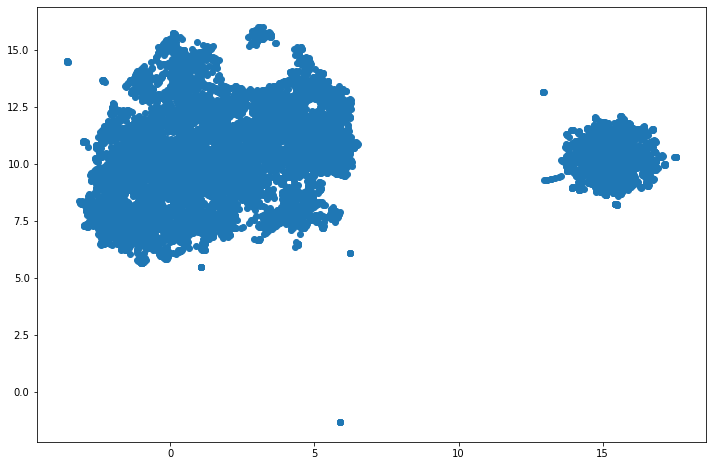

In [18]:
# reduce to two dimentions and plot result
clusterable_embedding = reducer.fit_transform(np.asmatrix(numpy_array))
plt.figure(figsize=(12,8))
plt.scatter(clusterable_embedding[:,0],clusterable_embedding[:,1])
clusterable_embedding.shape
print(clusterable_embedding)

##### Body Text

[[ 4.8522654  7.29898  ]
 [10.4329405 11.176286 ]
 [11.461031   2.9171674]
 ...
 [ 6.1377482  6.2594786]
 [ 7.7757587  5.3794594]
 [ 7.9246597 11.538631 ]]


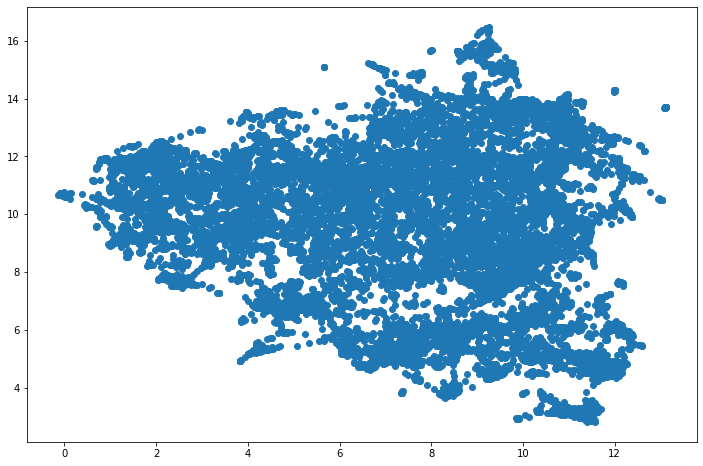

In [19]:
clusterable_embedding2 = reducer.fit_transform(np.asmatrix(numpy_array2))
plt.figure(figsize=(12,8))
plt.scatter(clusterable_embedding2[:,0],clusterable_embedding2[:,1])
clusterable_embedding2.shape
print(clusterable_embedding2)

## HDBSCAN

We are trying to run vectorization and separate the literature by two ways, the first one is HDBSCAN. HDBSCAN is a clustering algorithm developed by Campello, Moulavi, and Sander.<sup>[7](https://link.springer.com/chapter/10.1007%2F978-3-642-37456-2_14)</sup> It extends DBSCAN (a classic density-based spatial algorithm) by converting it into a hierarchical clustering algorithm, and then using a technique to extract a flat clustering based in the stability of clusters. 

In [20]:
import hdbscan
import numpy as np
import seaborn as sns
import pandas as pd

In [21]:
#Abstract
clusterer = hdbscan.HDBSCAN(min_cluster_size=2, gen_min_span_tree=True)
clusterer=clusterer.fit(clusterable_embedding)

In [22]:
#Body Text
clusterer2=clusterer.fit(clusterable_embedding2)

### Visualization

#### Abstract

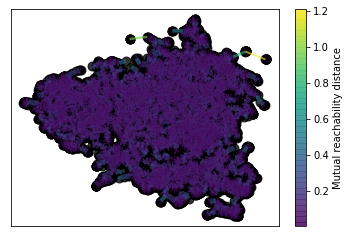

In [23]:
#Build the minimum spanning tree
clusterer.minimum_spanning_tree_.plot(edge_cmap='viridis',
                                      edge_alpha=0.6,
                                      node_size=80,
                                      edge_linewidth=2)

In [64]:
#Build the cluster hierarchy
clusterer.single_linkage_tree_.plot(cmap='viridis', colorbar=True)

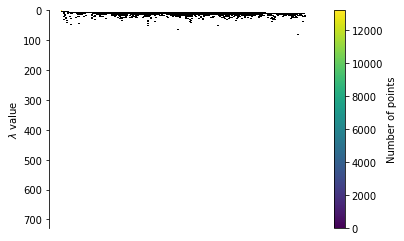

In [25]:
#Condense the cluster tree
clusterer.condensed_tree_.plot()

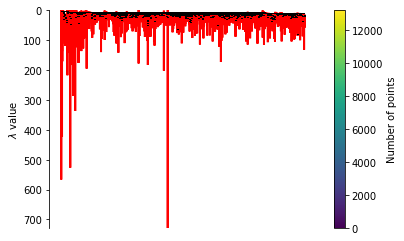

In [26]:
#Extract the clusters
clusterer.condensed_tree_.plot(select_clusters=True, selection_palette=sns.color_palette())

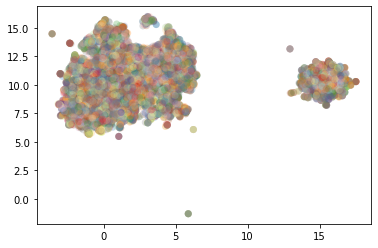

In [27]:
#clusterer = hdbscan.HDBSCAN(min_cluster_size=10, prediction_data=True).fit(clusterable_embedding)
color_palette = sns.color_palette('Paired',max(clusterer.labels_))
cluster_colors = [color_palette[x] if x >= 0 and x<max(clusterer.labels_)
                  else (0.5, 0.5, 0.5)
                  for x in clusterer.labels_]
cluster_member_colors = [sns.desaturate(x, p) for x, p in
                        zip(cluster_colors, clusterer.probabilities_)]
plt.scatter(*clusterable_embedding.T, s=50, linewidth=0, c=cluster_member_colors, alpha=0.25)

We got more than 1000 clustering groups totally, so HDBSCAN may not be the best way to cluster, and then we will try K-Means.

#### Body Text

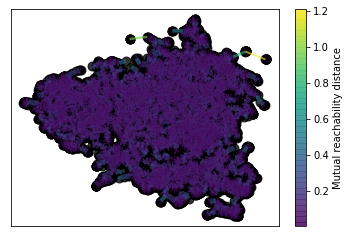

In [28]:
#Build the minimum spanning tree
clusterer2.minimum_spanning_tree_.plot(edge_cmap='viridis',
                                      edge_alpha=0.6,
                                      node_size=80,
                                      edge_linewidth=2)

In [ ]:
#Build the cluster hierarchy
clusterer2.single_linkage_tree_.plot(cmap='viridis', colorbar=True)

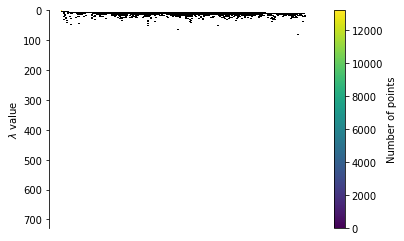

In [29]:
#Condense the cluster tree
clusterer2.condensed_tree_.plot()

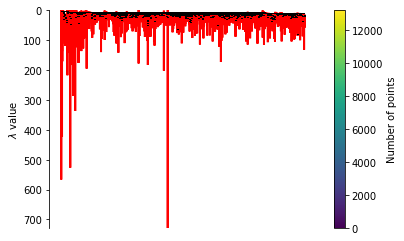

In [30]:
#Extract the clusters
clusterer2.condensed_tree_.plot(select_clusters=True, selection_palette=sns.color_palette())

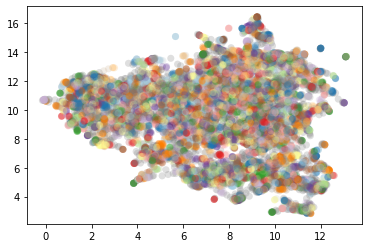

In [31]:
#clusterer = hdbscan.HDBSCAN(min_cluster_size=10, prediction_data=True).fit(clusterable_embedding)
color_palette = sns.color_palette('Paired',max(clusterer2.labels_))
cluster_colors = [color_palette[x] if x >= 0 and x<max(clusterer2.labels_)
                  else (0.5, 0.5, 0.5)
                  for x in clusterer.labels_]
cluster_member_colors2 = [sns.desaturate(x, p) for x, p in
                        zip(cluster_colors, clusterer2.probabilities_)]
plt.scatter(*clusterable_embedding2.T, s=50, linewidth=0, c=cluster_member_colors2, alpha=0.25)

## K-means

Then we will see what k-means clustering to be like and what makes it different from HDBSCAN. First step is finding best k-value. Distortion computes the sum of squared distances from each point to its assigned center. When distortion is plotted against k there will be a k value after which decreases in distortion are minimal. This is the desired number of clusters.

In [32]:
from sklearn.cluster import KMeans

#### Abstract

In [34]:
from scipy.spatial.distance import cdist
distortions = []
K = range(2, 40)
for k in K:
    k_means = KMeans(n_clusters=k, random_state=42).fit(clusterable_embedding)
    k_means.fit(clusterable_embedding)
    distortions.append(sum(np.min(cdist(clusterable_embedding, k_means.cluster_centers_, 'euclidean'), axis=1)) / pd.DataFrame(df).shape[0])

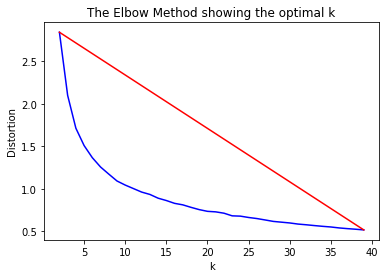

In [35]:
X_line = [K[0], K[-1]]
Y_line = [distortions[0], distortions[-1]]

# Plot the elbow
plt.plot(K, distortions, 'b-')
plt.plot(X_line, Y_line, 'r')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

The best k-value is about 9 to 12, so we determined the best one is 10

In [36]:
kmeans = KMeans(n_clusters=10, random_state=0).fit_predict(clusterable_embedding)
kmeans

array([8, 1, 3, ..., 9, 5, 8], dtype=int32)

In [37]:
kmeans_clustering_model=KMeans(n_clusters=10, random_state=0)
kmeans_clustering_model.fit(clusterable_embedding)
kmeans_label=kmeans_clustering_model.labels_

In [38]:
df['cluster_']=kmeans_label

Now we can compare two ways of clustering. Usually K-Means works well for “round” or spherical, and when most dense in the center of the sphere
not contaminated by noise/outliers. Our dataset does not centered with arbitrary shapes and too many noises, therefore K-Means works well here.

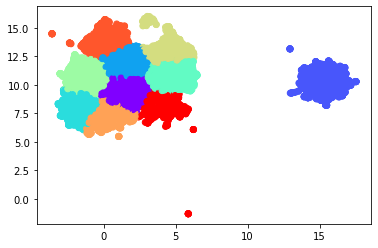

In [39]:
plt.scatter(clusterable_embedding[:,0],clusterable_embedding[:,1], c=kmeans, cmap='rainbow')

#### Body Text

In [41]:
from scipy.spatial.distance import cdist
distortions2 = []
K2 = range(2, 40)
for k in K:
    k_means2 = KMeans(n_clusters=k, random_state=42).fit(clusterable_embedding2)
    k_means2.fit(clusterable_embedding2)
    distortions2.append(sum(np.min(cdist(clusterable_embedding2, k_means2.cluster_centers_, 'euclidean'), axis=1)) / pd.DataFrame(df).shape[0])

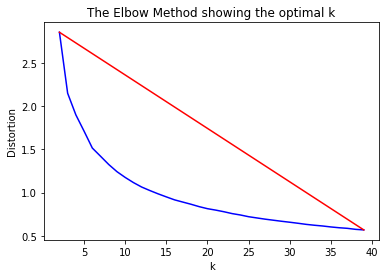

In [42]:
X_line2 = [K2[0], K2[-1]]
Y_line2 = [distortions2[0], distortions2[-1]]

# Plot the elbow
plt.plot(K2, distortions2, 'b-')
plt.plot(X_line2, Y_line2, 'r')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

In [43]:
kmeans2 = KMeans(n_clusters=10, random_state=0).fit_predict(clusterable_embedding2)
kmeans2

array([0, 8, 4, ..., 0, 7, 5], dtype=int32)

In [44]:
kmeans_clustering_model2=KMeans(n_clusters=10, random_state=0)
kmeans_clustering_model2.fit(clusterable_embedding2)
kmeans_label2=kmeans_clustering_model2.labels_

In [45]:
df['textcluster_']=kmeans_label2

## Topic Modeling

After find the best clustering, we are going to labeled each topic. Most frequent methods of topic modeling, including latent Dirichlet Allocation.<sup>[9](http://www.jmlr.org/papers/volume3/blei03a/blei03a.pdf)</sup> , a generative statistical model that uses unobserved groups to explain why some parts of a corpus are similar, and non-negative matrix factorization, do not work for embeddings methods as we chose. Indeed, LDA model posits that each document is a mixture of a small number of topics, where each topic is described by a distribution of words and each word's presence in the document can be attributed to one of these topics. As for further work, we will re-preprocessing text, using TFIDFVectorizer or CountVectorizer to then find the topics each models.

# Semantic search

### Cosine similarity
An amazing use of the embeddings we obtained with our fine-tuned Sentence Transformer model is to query the corpus and find the most similar embeddings to the query's embeddings. This can be simply done by calculating cosine similarity among embeddings, and then select the least-distant ones as the most relevant to the query.  
Here we propose a semantic search system where the user can input a question about COVID-19 and they will get the top 5 most relevant articles from the corpus. We suggest to interrogate our system with questions taken from the Kaggle's suggested [tasks](https://www.kaggle.com/allen-institute-for-ai/CORD-19-research-challenge/tasks).

In [4]:
## call searches and get table out
from scripts import new_searches
import pandas as pd
from sentence_transformers import SentenceTransformer
import os

# import model
embedder = SentenceTransformer('model1') #this or the model we trained and saved

# load corpus
df_covid = pd.read_pickle(os.getcwd()+'/data/compelete_dataframe.pkl')

In [6]:
# asking the user
query = input('What would you like to know from CORD-19? ')
print('\nUse abstracts:')
new_searches.sem_search(query, embedder, df_covid['abstract'].to_list(), df_covid['abs_embeddings'].to_list(),df_covid)

What would you like to know from CORD-19?  coronavirus



Use abstracts:





Top 5 most similar articles in corpus:
+-----------------------------------------------------------------------+------------------------------------------------------------------------+-------------------+--------+
|                                Abstract                               |                                 Title                                  |      Journal      | Score  |
+-----------------------------------------------------------------------+------------------------------------------------------------------------+-------------------+--------+
| since the severe acute respiratory syndrome coronavirus 2  sars cov 2 |                                  nan                                   |        nan        | 0.7367 |
|                                disease                                |                                                                        |                   |        |
|                                                           

In [7]:
# asking the user (slower)
print('\nUse full text:')
new_searches.sem_search(query, embedder, df_covid['body_text'].to_list(), df_covid['body_embeddings'].to_list(),df_covid)


Use full text:





Top 5 most similar articles in corpus:
+----------------------------------------------------------------------------+-----------------------------------------------------------------------------+----------------------+--------+
|                                  Abstract                                  |                                    Title                                    |       Journal        | Score  |
+----------------------------------------------------------------------------+-----------------------------------------------------------------------------+----------------------+--------+
|                                                                            |   Niclosamide Is a Proton Carrier and Targets Acidic Endosomes with Broad   |     PLoS Pathog      | 0.6462 |
|                                                                            |                              Antiviral Effects                              |                      |     

# Conclusion

Great AI stuff I guess!